In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import math

#### Choose a Device

In [2]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Transformer Definition

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [5]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(device)
        tgt_mask = (tgt_mask & nopeak_mask).to(device)
        return src_mask, tgt_mask


    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
    
        dec_output = src_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output).to(device)
        return output

### Preprocess Data

In [9]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [10]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), dtype = torch.long)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char) + 1
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_index(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]) # Target is represented in index.
    return input, target

### Instantiate Model

In [11]:
# Instantiate the Transformer model
d_model = 128
num_heads = 4
num_layers = 4
d_ff = 512
# d_ff = 2048
# d_ff = 128
max_seq_length = 128
dropout = 0.1

model = Transformer(
    src_vocab_size=100,
    tgt_vocab_size=100,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    max_seq_length=max_seq_length,
    dropout=dropout
)
model.to(device)

Transformer(
  (encoder_embedding): Embedding(100, 128)
  (decoder_embedding): Embedding(100, 128)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=128, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-3): 4 x DecoderLayer(
     

### Generate Text

In [12]:
def generate_text(model,target,start_seq='Wha', gen_len=10,temperature=1.0):
    model.eval()  # Set the model to evaluation mode
    
    indices = ""
    tensor = start_seq[0]
    for char in tensor:
        indices += all_chars[char-1] 
        
    input_seq = start_seq
    
    for _ in range(gen_len):
        with torch.no_grad():
            output = model(input_seq, target)
        
        # Get the last output and convert to probabilities
        next_char_logits = output[-1, 0, :] # Shape: (output_dim)
        next_char_probs = torch.softmax(next_char_logits, dim=-1)/temperature

        predicted_char_index = torch.argmax(next_char_probs)
        predicted_char = all_chars[predicted_char_index]
        
        indices += predicted_char
        
        # Append the next character to the input sequence
        next_char_tensor = torch.tensor([predicted_char_index], dtype=torch.long).unsqueeze(1).to(device)
        input_seq = torch.cat([input_seq, next_char_tensor], dim=1)[:, 1:]
    
    return indices


### Training Procedure

In [13]:
# Number of iterations.
iters       = 20000
# Number of printing iterations
print_iters = 200   

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    opt.zero_grad()
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    input = input[None] 
    target = target[None] 
    predicted = model(input,input)
    predicted = predicted.permute(0,2,1)
    loss = loss_func(predicted,target)
    
    loss.backward()
    loss_sum += loss.item()                                # Accumulate the loss.
    opt.step()

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(generate_text(model,target,start_seq = input)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:199/20000 loss:2.8540650606155396
generated sequence: ad, but it may well be told.

KING RICHARD III:
Hoyday, a riddle! neither good nor bad!
Why dost thou run so many mile about,
Whm		ufmiuui

iter:399/20000 loss:2.5763925778865815
generated sequence: nd Clarence. O, what cause have I,
Thine being but a moiety of my grief,
To overgo thy plaints and drown thy cries!

Boy:
Good ae	nI	o		ep

iter:599/20000 loss:2.525914455652237
generated sequence: at, were I crown'd the most imperial monarch,
Thereof most worthy, were I the fairest youth
That ever made eye swerve, had forceu		uj	f	u	

iter:799/20000 loss:2.4601682674884797
generated sequence:  praise us, as little accuse
us.

CAMILLO:
You pay a great deal too dear for what's given freely.

ARCHIDAMUS:
Believe me, I speuffot		us	

iter:999/20000 loss:2.4101247107982635
generated sequence: on and whose heart together
Affliction alters.

PERDITA:
One of these is true:
I think affliction may subdue the cheek,
But not 	huuh	uif	

iter:1

iter:8599/20000 loss:1.7120979899168014
generated sequence: is hand to wield a sceptre, and himself
Likely in time to bless a regal throne.
Make much of him, my lords, for this is he
Must ofufo		u		

iter:8799/20000 loss:1.7391123616695403
generated sequence: up to-night.
Give me some ink and paper.
What, is my beaver easier than it was?
And all my armour laid into my tent?

CATESBY:
etibfs

iter:8999/20000 loss:1.7114160394668578
generated sequence:  husband and my lord, my lord and husband;
I am your wife in all obedience.

SLY:
I know it well. What must I call her?

Lord:
Mufuffo		uo

iter:9199/20000 loss:1.7198930078744887
generated sequence: 
At that sad stop, my lord,
Where rude misgovern'd hands from windows' tops
Threw dust and rubbish on King Richard's head.

n	u	fo	u	

iter:9399/20000 loss:1.7340651601552963
generated sequence:  waters and o'erbear
What they are used to bear.

MENENIUS:
Pray you, be gone:
I'll try whether my old wit be in request
With thujji			uje

iter:9599/

generated sequence:  your time. Proceed.

ISABELLA:
I went
To this pernicious caitiff deputy,--

DUKE VINCENTIO:
That's somewhat madly spoken.

ISABu	st	uiu		

iter:16999/20000 loss:1.6014473128318787
generated sequence: ray, what nobleman is that
That with the king here resteth in his tent?

First Watchman:
'Tis the Lord Hastings, the king's chie	o		ubfoiu

iter:17199/20000 loss:1.594647770524025
generated sequence: tiger's heart wrapt in a woman's hide!
How couldst thou drain the life-blood of the child,
To bid the father wipe his eyes withaio			t	uf	

iter:17399/20000 loss:1.6286761271953583
generated sequence: ee something more than man
And after that trust to thee.

CAMILLO:
Have you thought on
A place whereto you'll go?

FLORIZEL:
Not		u		f		ft

iter:17599/20000 loss:1.615428059697151
generated sequence: ness, the life of Rome!
Call all your tribes together, praise the gods,
And make triumphant fires; strew flowers before them:
Une				uif	u

iter:17799/20000 loss:1.60642803966999

#### Training Loss Curve

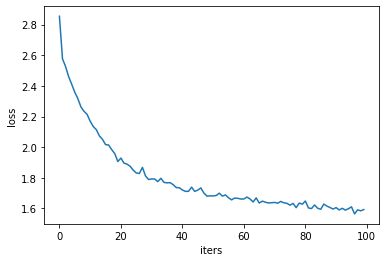

In [14]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.array(all_losses))
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [15]:
rand_input, rand_target = get_input_and_target()  
rand_input = rand_input[None].to(device)
rand_target = rand_target[None].to(device)
generate_text(model,rand_target,start_seq = rand_input,gen_len=600)

"ng spawn how can he flatter--\nThat's thousand to one good one--when you now see\nHe had rather venture all his limbs for honour\nTe\tu\tfojeubsjuuoeubsufbo\t\tsfiiXibo\t\t\tu\tbst\toe\tu\tsusesu\tss\tusesiijbseu\tstuesju\tssXFsubo\tufo\tbsfufse\ttfsuobbubo\tuboff\tufsfubsestfXi\tu\tuseo\t\tofo\t\te\t\tof\tsoeuufsbbiboeuuu\tuof\tue\tu\tuf\tf\tf\tuffu\tf\tfbboof\t\tuf\t\t\tfo\tuffiOf\toeu\tseuofs\tsf\tu\tsf\teoo\toeu\toessu\tsfs\tof\tf\tsibu\tu\tf\teuueseuu\tuuesufe\t\t\tsfooboe\t\t\t\tu\tesu\t\tu\tu\tsususu\tss\tususooeesuu\tsuuuseu\tssbpsue\t\tuf\t\tesfufsu\tufsu\teeue\t\tue\tff\tufsfuesusufbo\tu\tusu\t\t\t\tf\t\t\tu\t\t\tf\ts\tuuufseeoe\tuuuu\tu\tf\tuu\tu\tuf\tf\tf\tuffu\tf\tfee\t\tf\t\tuf\t\t\tf\t\tuffosf\t\tuu\tsuu\tfs\tsf\tu\tsf\tu\t\t\t\tuu\t\tussu\tsfs\t\tf\tf\tsoeu\tu\tf\tuuuusuuu\tuuusufu\t\t\tsf\t\te\tu\t\t\t\tu\tusu\t\tu\tu\tsususu\tss\tusus\t\tuusuu\tsuuusuu\tssefsuu\t\tuf"

### Analysis

In attempting to printing the output of the current model, the main change was for the model to pass in the input twice,since the target gave away the answers. This prevented the model from generalizing to other input and thus had bad behavior in printing words.